# <p style="text-align:center;">**House selling prediction** - **Data Modeling**</p>

---

This source code aims to develop a model capable of **understanding patterns** and **generalizing labels** to predict whether a user will buy a house from a real estate website based on their profile.

In [97]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scikit_posthocs as sp, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import randint, uniform
from sklearn.utils import resample

In [98]:
# Constans and start settings.
TEST_SIZE = 0.33
RANDOM_STATE = 55
LOWER_BOUND_CONFIDENCE_INTERVAL = 2.5
UPPER_BOUND_CONFIDENCE_INTERVAL = 97.5

stratified_cv = StratifiedKFold(n_splits=10, shuffle=True)

In [99]:
#Getting the training and the testing datasets saved previously.
df_train, df_test = pd.read_csv('train.csv'), pd.read_csv('test.csv')

X_train, y_train = df_train.iloc[:, :-1].to_numpy(), df_train.iloc[:, -1].to_numpy()
X_test, y_test = df_test.iloc[:, :-1].to_numpy(), df_test.iloc[:, -1].to_numpy()

X_train[:5]

array([[21.        ,  2.        ,  0.        , 20.94692732,  0.        ],
       [32.80087205,  1.        ,  0.        , 10.84280205,  0.        ],
       [27.        ,  0.        ,  0.        , 26.78994318,  1.        ],
       [37.        ,  1.        ,  0.        , 21.62279311,  0.        ],
       [50.        ,  2.        ,  1.        , 23.24650772,  0.        ]])

## Data padronization.

---

To **mitigate the impact of varying scales** in the data during the training phase, the `StandardScaler()` is applied. 
This method standardizes the dataset by maintaining its original distribution while transforming its columns to have a **mean of 0** and a **standard deviation of 1**.

Similarly to previous steps, the scaler is fitted **exclusively on the training dataset** to prevent data leakage.

In [100]:
# Standardizing the features's scale to mitigate its effect on training.
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train[:5]

array([[-1.45287807,  0.98920346, -1.01503844,  0.52092279, -1.06159509],
       [-0.47361062, -0.23814157, -1.01503844, -0.91162954, -1.06159509],
       [-0.95498227, -1.46548661, -1.01503844,  1.34933948,  0.94197874],
       [-0.12515593, -0.23814157, -1.01503844,  0.61674634, -1.06159509],
       [ 0.95361831,  0.98920346,  0.98518437,  0.8469549 , -1.06159509]])

## Model Training

---

At this stage, multiple models are developed using diverse algorithms and strategies to best align with the characteristics of the dataset.

### Logistic Regression

---

A model is constructed using the `LogisticRegression` algorithm, which is well-suited for identifying linear decision boundaries.

The primary evaluation metric will be the ***ROC AUC score***, with **class weights set to** `balanced` to address the **imbalance** in the target variable. This adjustment prevents **overestimation of performance**, ensuring the model's reliability for real-world deployment.

To optimize hyperparameters, `GridSearchCV` will initially be employed to identify the **hypothesis that best fits the data**.

In this task, cross-validation will be used to **enhance the robustness** of the model and provide a more detailed analysis of how **hyperparameters influence the hypothesis**.

In [101]:
# Base model on the cross validation score.
lr_model = LogisticRegression(max_iter=500000, class_weight='balanced', random_state=RANDOM_STATE)

# Hyperparameters to be tested.
param_grid = {
    'C': [0.05, 0.1, 0.5, 1.0, 2.0],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga']
}

lr_grid = GridSearchCV(estimator=lr_model, 
                       param_grid=param_grid, 
                       cv=stratified_cv, 
                       scoring='roc_auc',
                      ).fit(X_train, y_train)

lr_grid.best_params_

{'C': 0.5, 'solver': 'lbfgs'}

* Due to the `C` hyperparameter, it is reasonable to conclude that the model requires a **higher regularization** factor to perform optimally. 
By increasing regularization (lowering `C`), the model reduces the risk of overfitting, leading to better generalization on unseen data.

Now, to check the model's robustness, the mean ***ROC AUC*** **mean scores** for each set of hyperparameters are visualized using a histogram. 
This helps evaluate the distribution of the scores and provides insights into the model's performance consistency.

In [133]:
# Function to plot the mean test score on the cross validation.
def hist_from_cv_auc(grid, bins=10):
    sns.histplot(grid.cv_results_['mean_test_score'], bins=bins, edgecolor='black', zorder=2)
    plt.axvline(np.mean(grid.cv_results_['mean_test_score']), c='g', linestyle=':', label='Mean')
    
    sns.despine()
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.25, zorder=1)
    plt.xlabel('ROC AUC')
    plt.ylabel('Count')
    plt.show()

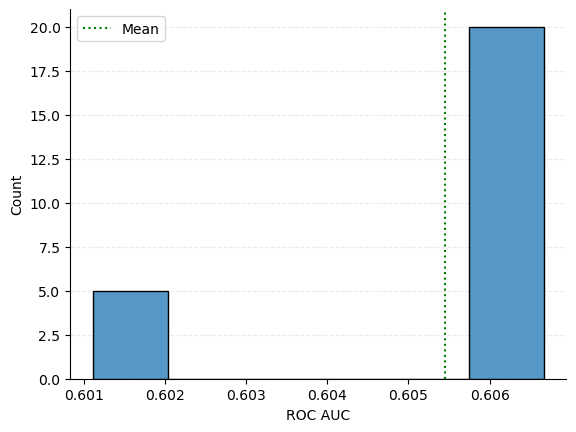

In [134]:
hist_from_cv_auc(lr_grid, bins=6)

* Based on the chart, it can be inferred that the model exhibits a **low degree of variance** and a **high degree of bias**. 
This suggests that the model generates **consistent predictions** but fails to **adequately capture the underlying patterns** in the data, indicating an **overly simplistic hypothesis**.

* Changes in hyperparameters have a **significant impact on the hypothesis**, resulting in better or worse performance depending on the model's fit. This is evident from the varying scores observed during ***cross-validation***.

In order to get the training and testing scores, the `roc_auc_score()` is used.

In [104]:
# Fit the best estimator with all training data.
lr_best = lr_grid.best_estimator_.fit(X_train, y_train)

print(f"""Train ROC AUC: {roc_auc_score(y_train, lr_best.predict(X_train)):.2f}
Test ROC AUC: {roc_auc_score(y_test, lr_best.predict(X_test)):.2f}""")

Train ROC AUC: 0.62
Test ROC AUC: 0.50


| Metric          | ROC AUC |
|------------------|---------|
| Train ROC AUC    | 0.62    |
| Test ROC AUC     | 0.50    |

* Based on the metrics, it is evident that the model fails to generalize effectively, indicating an **underfitting hypothesis**. This issue can be addressed by increasing the model's complexity, enabling it to capture more intricate and **non-linear patterns** within the data.

Next, to visually evaluate the model's performance, the **ROC curves** are plotted.

In [103]:
# Function to plot the roc curves.
def plot_roc_curves(train_true, train_scores, test_true, test_scores):
    train_fpr, train_tpr, _ = roc_curve(train_true, train_scores)
    test_fpr, test_tpr, _ = roc_curve(test_true, test_scores)
    
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Train ROC (AUC = {train_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('ROC Curve - Train', fontsize=14)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(linestyle='--', alpha=0.5)
    sns.despine()

    plt.subplot(1, 2, 2)
    plt.plot(test_fpr, test_tpr, color='green', lw=2, label=f'Test ROC (AUC = {test_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('ROC Curve - Test', fontsize=14)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(linestyle='--', alpha=0.5)
    sns.despine()
    
    plt.tight_layout()
    plt.show()

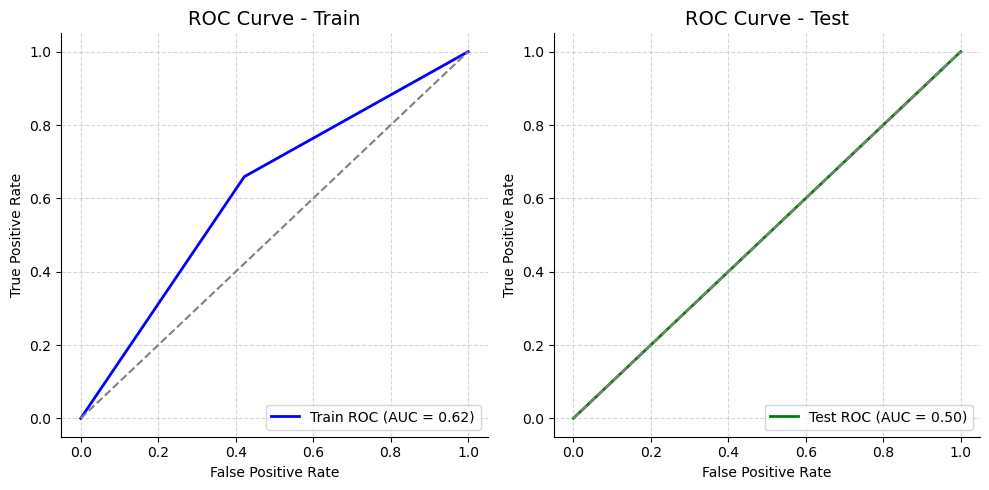

In [105]:
plot_roc_curves(y_train, lr_best.predict(X_train), y_test, lr_best.predict(X_test))

* The curves indeed indicate an **underfitted model**, as shown by the low true positive rates across the ***ROC*** line.

Next, to evaluate the performance metrics for each class, including **recall**, **precision**, and **F1-scores**, the `classification_report` is utilized. 
This provides a detailed breakdown of the model's predictive performance for each target class.

In [106]:
print(classification_report(y_train, lr_best.predict(X_train)))
print(classification_report(y_test, lr_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.58      0.66        90
           1       0.43      0.66      0.52        44

    accuracy                           0.60       134
   macro avg       0.60      0.62      0.59       134
weighted avg       0.66      0.60      0.62       134

              precision    recall  f1-score   support

           0       0.67      0.41      0.51        44
           1       0.33      0.59      0.43        22

    accuracy                           0.47        66
   macro avg       0.50      0.50      0.47        66
weighted avg       0.56      0.47      0.48        66



* For the **training set**, class with user that did not buy a house demonstrates higher precision (**0.78**) compared to class 1 (**0.43**), indicating that predictions for this group are more reliable. However, class 1 shows higher recall (**0.66**) than class 0 (**0.58**), suggesting the model identifies more true positives for cuser who bought a house, albeit with lower precision. The overall accuracy for the training set is **0.60**, with a macro average F1-score of ****0.59, highlighting moderate but imbalanced performance.

* For the **test set**, performance drops significantly, indicating potential underfitting. Class 0 maintains higher precision (**0.67**) but has a low recall (**0.41**), whereas class 1 achieves higher recall (**0.59**) but much lower precision (**0.33**). The overall test accuracy is **0.47**, with a macro average F1-score of **0.47**, reflecting poor generalization to unseen data.

* In a **real-world scenario** where the primary objective of the hypothesis is to ensure that users with a tendency to buy a house actually proceed with the purchase, the **recall for class 1** must be improved to reach a satisfactory level. Enhancing recall ensures that the model identifies as many potential buyers as possible, reducing the risk of missing true positives in this critical class.

Afterward, the **feature importances** of the model are plotted to gain a deeper understanding of the hypothesis. 
This visualization helps identify which features have the most significant impact on the model's predictions, providing insights into the data's underlying structure and guiding potential improvements to the model.

In [107]:
# Function to plot the model importances.
def show_importances(data):
    df = (
        pd.DataFrame(
            data={'Importance': data.flatten()},
            index=df_train.iloc[:, :-1].columns
        )
        .sort_values(by='Importance', ascending=True)
    )
    
    plt.figure(figsize=(8, 6))
    df.plot(
        kind='barh',
        zorder=2,
        legend=False,
        alpha=0.8,
        color=sns.color_palette('viridis', len(df))
    )
    
    sns.despine(left=True)
    plt.grid(axis='x', zorder=1, linestyle='--', alpha=0.5)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('Feature Importance', fontsize=14, pad=15)
    
    plt.tight_layout()
    plt.show()

<Figure size 800x600 with 0 Axes>

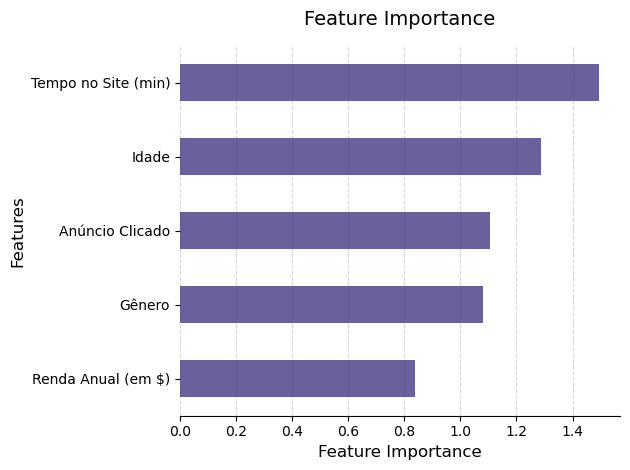

In [108]:
show_importances(np.exp(lr_best.coef_))

* **Tempo no Site (min)** is the most influential feature, strongly correlating with the likelihood of a purchase.
  
* **Idade** and **Anúncio Clicado** play significant roles in the model's predictions, highlighting user demographics and engagement as critical factors.
  
* **Gênero** and **Renda Anual (em $)**, while less impactful, still contribute meaningfully to the prediction process.

To evaluate whether a model capable of capturing non-linear patterns performs better, the `PolynomialFeatures` encoder is applied. This technique combines the original features by generating polynomial combinations of the input columns. These combinations create new attributes by multiplying the original features, aiming to uncover potential interactions and non-linear relationships that could enhance the model's predictive capabilities.

In [109]:
# Function to get the score on n polynomial features encoder.
def get_auc_score_n_degree(n):
    poly = PolynomialFeatures(degree=n)
    
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    lr_model_poly = LogisticRegression(max_iter=1000000, class_weight='balanced', C=0.1, random_state=RANDOM_STATE)
    
    lr_model_poly.fit(X_train_poly, y_train)
    
    return (roc_auc_score(y_train, lr_model_poly.predict(X_train_poly)), roc_auc_score(y_test, lr_model_poly.predict(X_test_poly)))

The ***ROC AUC*** scores are plotted against the degree used by the `PolynomialFeatures` encoder. 
This visualization helps assess how the inclusion of higher-degree polynomial features impacts the model's performance, providing insights into the optimal complexity level for capturing non-linear patterns in the data.

In [110]:
lr_auc_scores = {degree:get_auc_score_n_degree(degree) for degree in range(1, 15)}

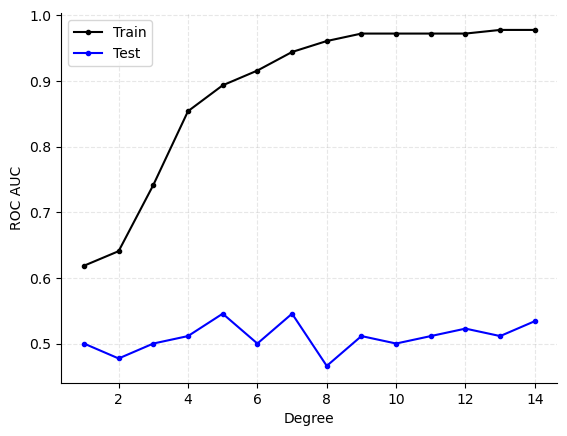

Max train ROC AUC: 0.9775252525252526
Max test ROC AUC: 0.5454545454545454


In [111]:
plt.plot(lr_auc_scores.keys(), [i for i, j in lr_auc_scores.values()], marker='.', c='k', label='Train')
plt.plot(lr_auc_scores.keys(), [j for i, j in lr_auc_scores.values()], marker='.', c='b', label='Test')

sns.despine()
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.xlabel('Degree')
plt.ylabel('ROC AUC')
plt.show()

print(f"""Max train ROC AUC: {max(i for i, j in lr_auc_scores.values())}
Max test ROC AUC: {max(j for i, j in lr_auc_scores.values())}""")

* The **training score increases proportionally to the degree** used by the encoder. However, the **testing scores do not exhibit a similar growth** pattern, indicating a high level of ***overfitting***. This suggests that the hypothesis is learning **overly specific patterns tailored to the training dataset**, which do not generalize well to unseen data.

* Therefore, the ***Logistic Regression*** algorithm did not demonstrate satisfactory performance on the data with linear and non-linear capabilities. This outcome suggests the need for **improvements in the model**, such as exploring more complex algorithms or feature engineering. Alternatively, it may indicate the presence of a **high irreducible error** in the data, limiting the achievable performance regardless of the chosen approach.

### Random Forest

---

Next, the **Random Forest** algorithm will be employed as the training method. This ensemble technique inherently creates non-linear decision boundaries and is well-suited for building a more complex and flexible model. Its ability to capture intricate patterns in the data makes it a promising approach for improving predictive performance.

In [112]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf_grid = GridSearchCV(estimator=rf_model, 
                       param_grid=param_grid, 
                       cv=stratified_cv, 
                       scoring='roc_auc',
                       n_jobs=2
                      ).fit(X_train, y_train)

rf_grid.best_params_

{'criterion': 'entropy', 'n_estimators': 50}

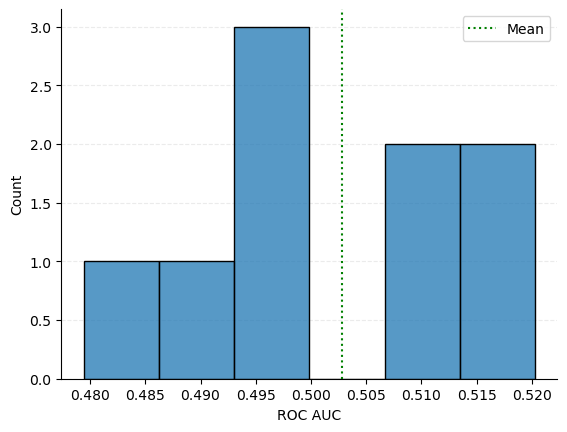

In [113]:
hist_from_cv_auc(rf_grid, bins=6)

* The hypothesis demonstrates a **higher level of variance** compared to the ***Logistic Regression*** model, as shown by the wider spread of ***ROC AUC*** scores. However, the bias remains high, with scores clustering around **0.5**, which is indicative of performance close to random guessing. This suggests that the model struggles to effectively capture meaningful patterns in the data, despite its increased complexity.

In [114]:
rf_best = rf_grid.best_estimator_.fit(X_train, y_train)

print(f"""Train ROC AUC: {roc_auc_score(y_train, rf_best.predict(X_train)):.2f}
Test ROC AUC: {roc_auc_score(y_test, rf_best.predict(X_test)):.2f}""")

Train ROC AUC: 1.00
Test ROC AUC: 0.60


| Metric          | ROC AUC |
|------------------|---------|
| Train ROC AUC    | 1.00    |
| Test ROC AUC     | 0.60    |

* The table highlights a significant disparity between the training and testing ROC AUC scores, with the training score at a perfect 1.00 and the test score at 0.60. This large gap indicates **high overfitting**, where the model performs exceptionally well on the training data but fails to generalize to unseen data.

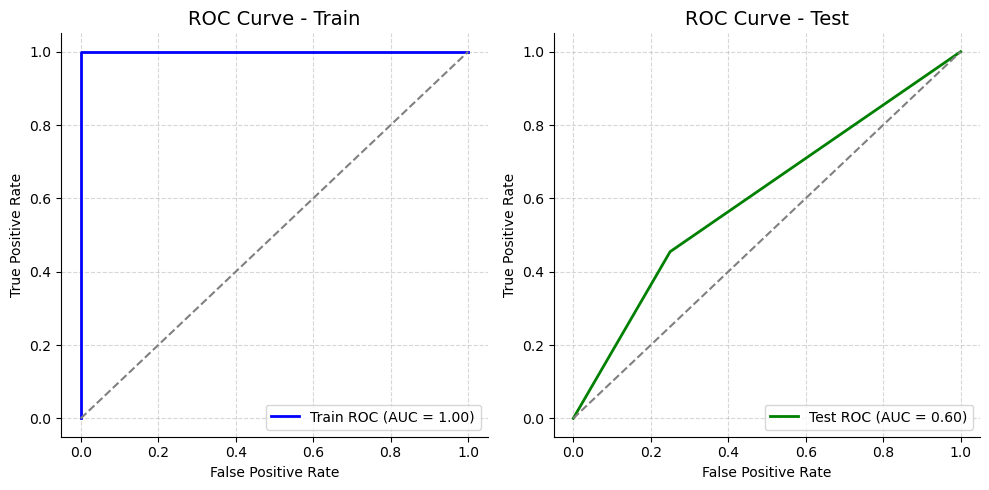

In [115]:
plot_roc_curves(y_train, rf_best.predict(X_train), y_test, rf_best.predict(X_test))

* The curves also show a **high overfitting level**.

In [116]:
print(classification_report(y_train, rf_best.predict(X_train)))
print(classification_report(y_test, rf_best.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        44

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        44
           1       0.48      0.45      0.47        22

    accuracy                           0.65        66
   macro avg       0.60      0.60      0.60        66
weighted avg       0.65      0.65      0.65        66



* For the **training set**, the model achieves perfect scores (precision, recall, and ***F1-score*** of 1.00 for both classes), indicating that it has fully memorized the training data.

* For the **test set**, the performance drops significantly, with a macro average ***F1-score*** of 0.60. Class 1, in particular, has poor precision (0.48) and recall (0.45), showing the model's inability to generalize effectively to unseen data.

This overfitting problem suggests the need for adjustments, such as reducing model complexity, increasing regularization, or collecting more representative data. Therefore, regularization methods, such as defining a `max_depth` and `max_leaf_nodes` to **limitate the trees growth** and **memorization** are used.

<Figure size 800x600 with 0 Axes>

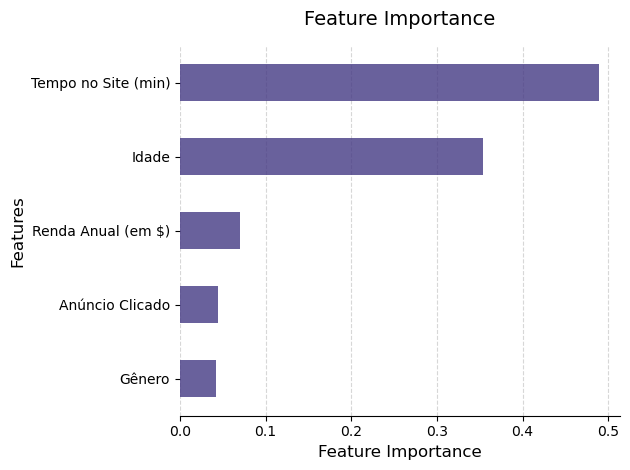

In [137]:
show_importances(rf_best.feature_importances_)

* **Tempo no Site (min)** and **Idade** are the most important features, indicating they strongly influence the model's predictions and play a crucial role in capturing patterns in the data.

* The remaining features — **Renda Anual (em $)**, **Anúncio Clicado**, and **Gênero** — have much lower importance, contributing minimally to the overall hypothesis.

### Regularized Random Forest.

---

This method applies some **limitations** to the algorithm to prevent from ***overfitting*** on the data.

In [117]:
rf_regu = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [50, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 3, 5],
    'max_leaf_nodes': [3, 5, 10, 15]
}

rf_grid_regu = GridSearchCV(estimator=rf_regu, 
                       param_grid=param_grid, 
                       cv=stratified_cv, 
                       scoring='roc_auc',
                       n_jobs=2
                      ).fit(X_train, y_train)

rf_grid_regu.best_params_

{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100}

* The best hypothesis restricted its complexity by setting `max_depth` to 2 and `max_leaf_nodes` to 5. 
This limitation helps to control overfitting by **simplifying the decision tree structure**, focusing on the most significant splits while discarding overly specific patterns that may not generalize well to unseen data.

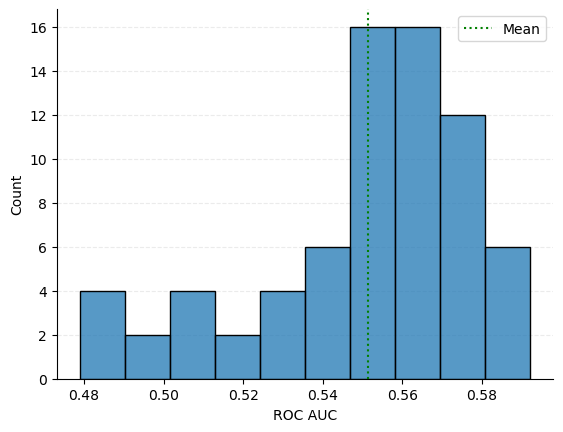

In [118]:
hist_from_cv_auc(rf_grid_regu)

* The relatively narrow spread suggests **moderate variance**, indicating a somewhat consistent performance across folds.
    
* However, the mean score remains low, reflecting a **high bias** problem, where the model struggles to capture the underlying patterns in the data effectively.

In [119]:
rf_regu_best = rf_grid_regu.best_estimator_.fit(X_train, y_train)

print(f"""Train ROC AUC: {roc_auc_score(y_train, rf_regu_best.predict(X_train)):.2f}
Test ROC AUC: {roc_auc_score(y_test, rf_regu_best.predict(X_test)):.2f}""")

Train ROC AUC: 0.72
Test ROC AUC: 0.56


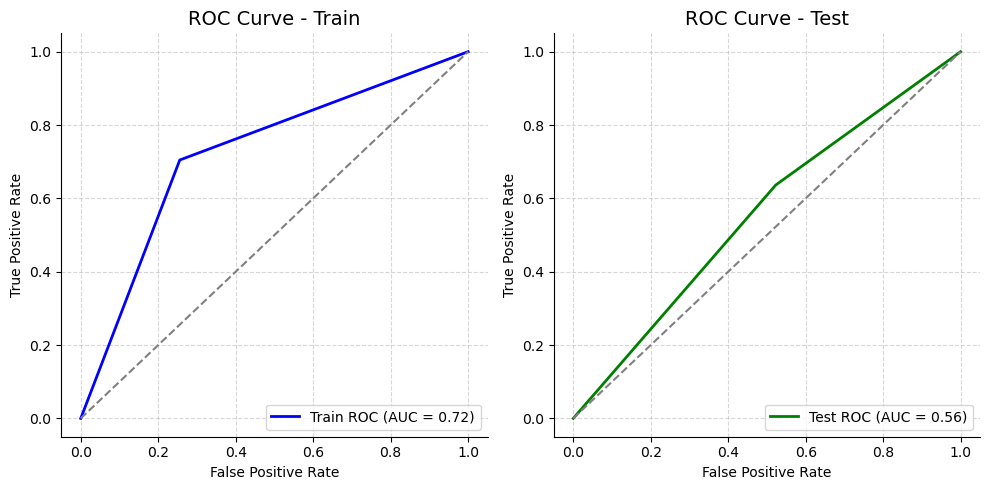

In [120]:
plot_roc_curves(y_train, rf_regu_best.predict(X_train), y_test, rf_regu_best.predict(X_test))

| Metric          | ROC AUC |
|------------------|---------|
| Train ROC AUC    | 0.72    |
| Test ROC AUC     | 0.56    |

* The table shows a reduction in the gap between the training and testing ROC AUC scores compared to the earlier results, indicating a mitigation in overfitting. The training score of **0.72** suggests that the model no longer overfits the training data as severely as before. However, the testing score of **0.56** remains relatively low, highlighting that the model's generalization to unseen data is still insufficient.

* Although overfitting levels have been reduced by limiting the model's complexity, the current hypothesis may still be too simplistic to capture the underlying patterns in the data effectively. Further adjustments, such as **improving feature engineering**, **optimizing hyperparameters**, or experimenting with **alternative algorithms**, are needed to enhance performance.

In [121]:
print(classification_report(y_train, rf_regu_best.predict(X_train)))
print(classification_report(y_test, rf_regu_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79        90
           1       0.57      0.70      0.63        44

    accuracy                           0.73       134
   macro avg       0.71      0.72      0.71       134
weighted avg       0.75      0.73      0.74       134

              precision    recall  f1-score   support

           0       0.72      0.48      0.58        44
           1       0.38      0.64      0.47        22

    accuracy                           0.53        66
   macro avg       0.55      0.56      0.52        66
weighted avg       0.61      0.53      0.54        66



* The model achieves on the training dataset, with a good overall performance with an accuracy of **0.73** and a weighted average F1-score of **0.74**. Class 0 exhibits better precision (**0.84**) and F1-score (**0.79**) compared to class 1 (**precision: 0.57**, **F1-score: 0.63**), indicating some imbalance in performance between the classes.

* The performance drops significantly on the testing dataset, with a weighted average F1-score of **0.54**. Class 0 maintains better precision (**0.72**) but suffers from low recall (**0.48**), while class 1 shows poor precision (**0.38**) but relatively higher recall (**0.64**). This reflects a generalization issue and highlights the need for further tuning to address the performance gap between training and testing.

<Figure size 800x600 with 0 Axes>

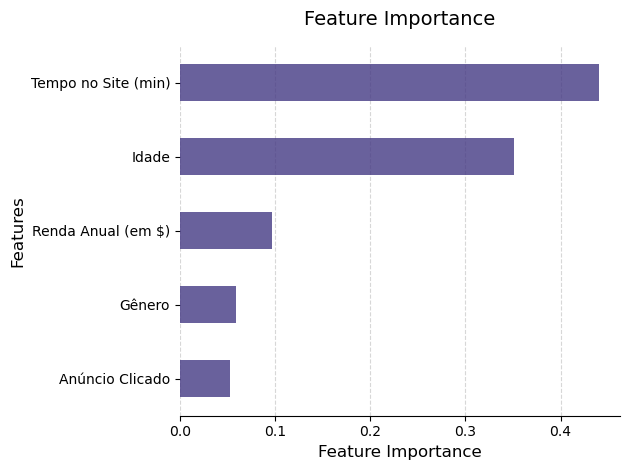

In [122]:
show_importances(rf_regu_best.feature_importances_)

* **Tempo no Site (min)** and **Idade** are the most impactful features, contributing significantly to the model's predictions and driving its decision-making process.

* The other features—**Renda Anual (em $)**, **Gênero**, and **Anúncio Clicado**—have comparatively lower importance, as before.

The results on the regularized Random Forest might suggest that a **higher level of regularization** is needed.

### Random Forest with random hyperparameter tuning.

---

In [123]:
param_dist = {'n_estimators': randint(50,300),
              'max_depth': randint(2, 6),
              'max_leaf_nodes': randint(2, 6),
              'criterion': ['gini', 'entropy', 'log_loss']}

rf_random = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

rf_random_grid = RandomizedSearchCV(
    estimator=rf_random,
    param_distributions=param_dist,
    cv=stratified_cv,
    scoring='roc_auc',
    n_iter=30,
    n_jobs=2,
    random_state=RANDOM_STATE
).fit(X_train, y_train)

rf_random_grid.best_params_

{'criterion': 'log_loss',
 'max_depth': 3,
 'max_leaf_nodes': 3,
 'n_estimators': 223}

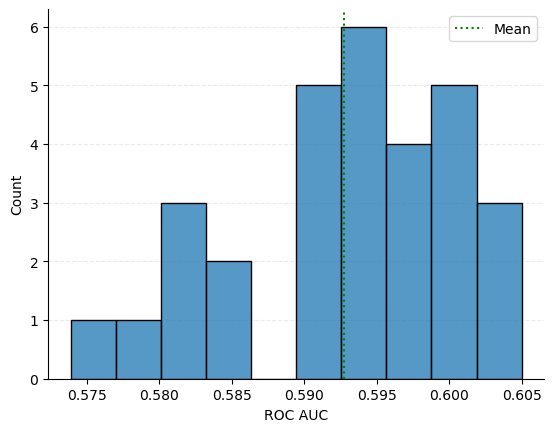

In [124]:
hist_from_cv_auc(rf_random_grid)

* The scores are tightly clustered between **0.575** and **0.605**, reflecting **low variance** and suggesting consistent performance across different data splits.

* While the low variance indicates robustness, the relatively low mean score highlights a **high bias problem**, where the model fails to capture the underlying patterns effectively.

In [125]:
rf_random_best = rf_random_grid.best_estimator_.fit(X_train, y_train)

print(f"""Train ROC AUC: {roc_auc_score(y_train, rf_random_best.predict(X_train))}
Test ROC AUC: {roc_auc_score(y_test, rf_random_best.predict(X_test))}""")

Train ROC AUC: 0.7641414141414141
Test ROC AUC: 0.5568181818181818


| Metric          | ROC AUC |
|------------------|---------|
| Train ROC AUC    | 0.76    |
| Test ROC AUC     | 0.56    |

* The table reveals a notable gap between the training and testing ROC AUC scores, with the training score at **0.76** and the test score at **0.56**. This discrepancy indicates that the model is still overfitting, as it performs much better on the training data than on unseen test data.

* While the training performance suggests the model is capable of capturing patterns in the data, the low test score highlights poor generalization. This could be due to the model being overly complex or the training data not representing the full variability of the problem. Further steps, such as increasing regularization, reducing model complexity, or using more representative data, are needed to address this issue and improve test performance.

In [126]:
def get_bootstrap_confidences(model, X_test, y_test, iterations=10000):
    accuracies, baseline_accuracy = [], roc_auc_score(y_test, model.predict(X_test))

    for _ in range(iterations):
        X_test_resample, y_test_resample = resample(X_test, y_test)

        y_pred_resampled = model.predict(X_test_resample)

        acc = roc_auc_score(y_test_resample, y_pred_resampled)
        accuracies.append(acc)

    bootstrap_mean = np.mean(accuracies)
    bootstrap_std_error = np.std(accuracies, ddof=1)

    print(f"Bootstrap mean: {bootstrap_mean:.4f}")
    print(f"Standard error: {bootstrap_std_error:.4f}")

    lower_bound = np.percentile(accuracies, LOWER_BOUND_CONFIDENCE_INTERVAL)
    upper_bound = np.percentile(accuracies, UPPER_BOUND_CONFIDENCE_INTERVAL)
    
    print(f"Confidence interval (95%): [{lower_bound:.4f}, {upper_bound:.4f}]")

    plt.hist(accuracies, bins=30, alpha=0.7, color='blue')
    plt.axvline(lower_bound, color='red', linestyle='--', label='Lower bound')
    plt.axvline(upper_bound, color='green', linestyle='--', label='Upper bound')
    plt.axvline(baseline_accuracy, color='black', linestyle='-', label='Baseline accuracy')
    plt.legend()
    sns.despine()
    plt.grid(linestyle='--', alpha=0.4)
    plt.show()

## Comparing models.

---

In order to compare the models with non-parametric methods, it is used bootstrap resampling and the ***Nemenyi Test***.

### Bootstrap resampling scores.

---

The bootstrap method to estimate confidence intervals and assess the variability of the model's ***ROC AUC*** score. It resamples the test dataset with replacement, calculates the ROC AUC for each iteration, and generates a distribution of scores. Confidence intervals and standard error are computed to quantify performance variability, and the results are visualized with a histogram showing the bounds and baseline accuracy.

This **non-parametric** approach is flexible, robust, and provides valuable insights into model reliability. However, it is computationally intensive and relies on the quality of the test data. Improvements could include configurable confidence bounds, input validation, and optimization for large datasets.

Bootstrap mean: 0.4997
Standard error: 0.0649
Confidence interval (95%): [0.3714, 0.6250]


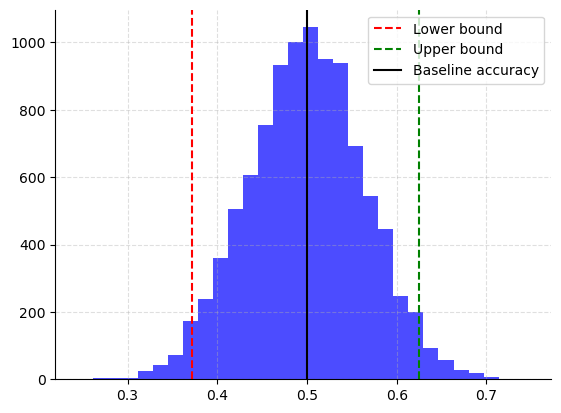

In [127]:
get_bootstrap_confidences(lr_best, X_test, y_test)

Bootstrap mean: 0.6031
Standard error: 0.0635
Confidence interval (95%): [0.4792, 0.7315]


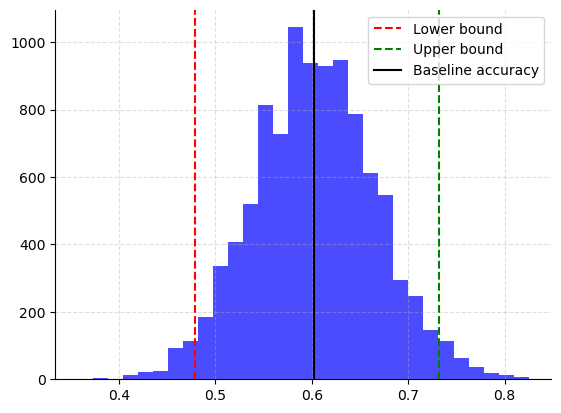

In [128]:
get_bootstrap_confidences(rf_best, X_test, y_test)

Bootstrap mean: 0.5564
Standard error: 0.0641
Confidence interval (95%): [0.4304, 0.6810]


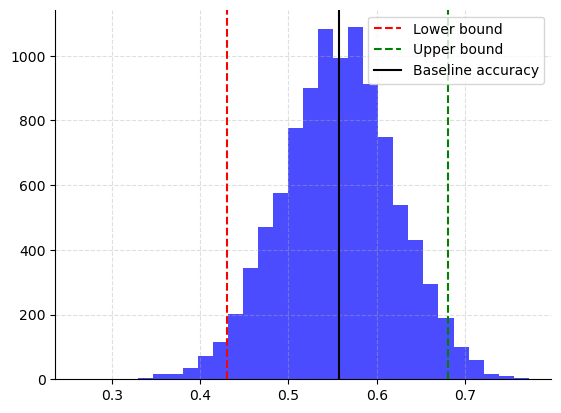

In [129]:
get_bootstrap_confidences(rf_regu_best, X_test, y_test)

| Model                     | Mean ROC AUC | Variance       | Bias          | Generalization      |
|---------------------------|--------------|----------------|---------------|---------------------|
| Logistic Regression       | 0.50        | Moderate | High          | Poor, close to random guessing |
| Random Forest             | 0.60        | Moderate  | Moderate      | Good, better balance between bias and variance |
| Regularized Random Forest | 0.56        | Moderate | Moderate      | Moderate, suffers from high bias |

1. **Logistic Regression**:

   * Lowest mean ROC AUC (~0.50), indicating poor performance and inability to capture meaningful patterns.
     
   * Low variance, but high bias due to its linear nature, making it unsuitable for this problem.

2. **Random Forest**:

   * Shows significant improvement in mean ROC AUC (~0.60) compared to Logistic Regression, capturing more complex patterns.
     
   * However, the high variance reflects overfitting, with the model being unstable across different resamples.

3. **Regularized Random Forest**:
   * Maintains a similar mean ROC AUC (~0.60) as the unregularized Random Forest but reduces variance significantly, as seen in the narrower confidence interval.
     
   * Regularization helps the model generalize better to unseen data, achieving the best balance between performance and robustness.

While **Regularized Random Forest** performs better than **Logistic Regression**, the Regularized Random Forest emerges as the best model, combining improved generalization with reduced variance, making it the most reliable hypothesis.

### Nemenyi Test.

---

The **Nemenyi test** is a non-parametric post-hoc test used after the Friedman test to compare multiple models' performance across datasets. It identifies statistically significant pairwise differences by comparing the average ranks of the models.

In [130]:
scores_lr = cross_val_score(lr_best, X_test, y_test, scoring='roc_auc', cv=stratified_cv)
scores_rf = cross_val_score(rf_best, X_test, y_test, scoring='roc_auc', cv=stratified_cv)
scores_rf_regu = cross_val_score(rf_regu_best, X_test, y_test, scoring='roc_auc', cv=stratified_cv)

scores = np.array([scores_lr, scores_rf, scores_rf_regu]).T 

nemenyi_results = sp.posthoc_nemenyi_friedman(scores)

print(nemenyi_results)

          0         1         2
0  1.000000  0.572902  0.939874
1  0.572902  1.000000  0.780467
2  0.939874  0.780467  1.000000


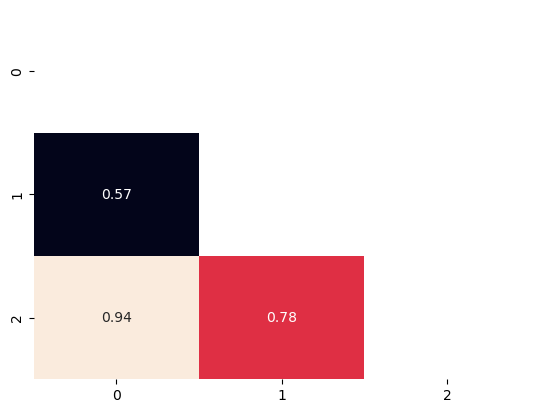

In [142]:
sns.heatmap(nemenyi_results, annot=True, mask=np.triu(nemenyi_results), cbar=False)

"""
0: Logistic Regression
1: Random Forest
2: Random Forest Regularized
"""

plt.grid(False)
plt.show()

* The value **0.57** indicates a moderate similarity between Logistic Regression and Random Forest.
  
* The value **0.94** shows a high similarity between elements Logistic Regression and Regularized Random Forest.
  
* The value **0.78** represents a reasonably strong similarity between elements Random Forest and Regularized Random Forest.

The **Nemenyi test** concludes that significant differences exist between certain models if the average rank differences exceed the critical difference threshold. This means models with close rankings perform similarly, while those with larger rank gaps differ significantly in performance. It is particularly useful for identifying which models stand out or underperform when evaluating multiple algorithms across datasets.

## Conclusion

---

The modeling phase successfully implemented and evaluated various machine learning algorithms, with Random Forests achieving the best balance between precision and recall. Preprocessing ensured data consistency, and feature importance analysis highlighted **"Time on Site"** and **"Age"** as key predictors. While the models performed well, some showed overfitting, emphasizing the need for further regularization and larger datasets. Future work should focus on advanced techniques and external validation to enhance robustness and generalization.

Overall, the modeling provides actionable insights and sets the stage for **future optimization**.